# COGS 108 - Final Project

## Introduction & Background

Every day drivers across the United States are stopped by police officers and issued traffic tickets. Often, drivers get pulled over for a few common reasons, such as speeding, distracted driving, equipment violations, tailgating and improper lane changes, etc. However, there might be other factors such as race, gender, and age, as well as time of day and location, that could impact both whether a driver is pulled over for a traffic violation, as well as the severity of the result.

As for background information, we did some research on the issue of police vehicle stops to further making predictions for this project. One of the articles we found indicated that a larger portion of black and hispanic drivers were being pulled over as opposed to white drivers. Additionally, a similar analysis conducted on traffic stop data showed that black and hispanic drivers were “more likely than white drivers to be searched following a traffic stop”. Plus, based on our own experiences, as well as those of others frequently heard about in the media, we came to the prediction that minority groups may possible be targeted with more severe or frequent citations. As for gender, there are existing stereotypes that women normally have a harder time on the road compared to men. Plus, gender ideologies that have been established lead us to the prediction that women tend to get pulled over more often. Looking into this data would help clarify these stereotypes and ideologies.

As we all know police officers can’t randomly pull drivers over and give tickets without having probable cause, like speeding or equipment violations. However, there might be cases where you feel as though you are not at fault but afraid to fight back against them because police officers have higher authority. In fact, we ourselves had experienced being pulled over and getting tickets for unreasonable situations. We believe this information may be important for us and others to figure out a way to back up ourselves under circumstances that we don’t feel at fault. In any case, whether these variables have some correlation or relationship with traffic violations would be both interesting and useful to know.

### Group Members:
- Amitoj Setia A11463602
- A14255637
- A13167547
- A13633912

### Research Question
What is the relationship between race/gender/age and traffic violation frequency in San Diego?

### Hypothesis
We predict that women drivers tend to get pulled over by police officers more often than male drivers. As for race, we predict that minority groups and nonwhite races also tend to get stopped more frequently than others. We also predict that teenagers and younger drivers commit more traffic violations than older drivers. After skimming through the dataset, we also predict that San Diego residents tend to get stopped in a longer time frame and frequently get tickets more than non-residents. 

### Dataset Information
- Police Vehicle Stops in 2016
- https://data.sandiego.gov/datasets/police-vehicle-stops/
- 103051 entries in raw dataset

The websites provides data for vehicle stops in separate datasets per year, and also provides a separate dataset with the results of each traffic stop. The vehicle stop dataset contains information such as the race, gender, and age of the person stopped, as well as the stop date, time, and location. 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from scipy.stats import ttest_ind

In [2]:
csvfile = 'vehicle_stops_2016_datasd.csv'
initial_df = pd.read_csv(csvfile)

In [3]:
#initial_df

## Data Cleaning, Visualization, and Analysis

To clean our data, we start off by removing rows with traffic stop information for equipment violations, as we are currently only looking at moving violation data. We also remove any rows where there is no recorded age data. 
We removed the 'obtained_consent', 'contraband_found', and 'property_seized' columns as there was not enough traffic stops where this was recoreded to perform a meaningful analysis. We also removed the 'stop_id' and 'stop_cause' columns as they were reduntant. We then dropped all rows with NaN data as well as rows containing an invalid entry in the 'timestamp' column.

Additionally, there is a "service_area" column that we were planning to use to see what areas had more frequent traffic violations, but we found it difficult to find a reference for what these area codes actually referred to, so we're omitting that column for now as well.

In [4]:
df = initial_df[initial_df.stop_cause == 'Moving Violation']
df = df[df.subject_age != 'No Age']
del df['obtained_consent']
del df['contraband_found']
del df['property_seized']
del df['service_area']
del df['stop_id']
del df['stop_cause']
df.dropna(subset=['timestamp'])
df.dropna(inplace=True)
df = df[['timestamp', 'stop_date', 'stop_time', 'subject_race', 'subject_sex', 'subject_age', 'sd_resident', 'arrested', 'searched']]

In [5]:
#df

The first information we want to look at is the statistics regarding which race of drivers was stopped most frequently. To do that, a bar graph provides a good representation of this data.

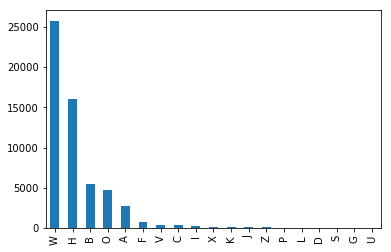

In [6]:
df['subject_race'].value_counts().plot(kind='bar')
f1 = plt.gcf()

Unfortunately, it looks like the provided dataset separates many races into very specific categories, which makes it hard for us to visualize the race data. To help with this, we can consolidate some of the lesser used categories into more useful and general categories.

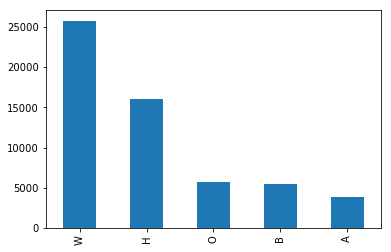

In [7]:
df_r = df.copy()
df_r.subject_race = df.subject_race.replace({"C" : "A", 
                                             "D" : "A",
                                             "F" : "O", 
                                             "G" : "O",
                                             "I" : "A",
                                             "J" : "A",
                                             "K" : "A",
                                             "L" : "O",
                                             "P" : "O",
                                             "S" : "O",
                                             "U" : "O",
                                             "V" : "A",
                                             "Z" : "A",
                                             "X" : "O",})
df_r['subject_race'].value_counts().plot(kind='bar')
f1 = plt.gcf()

Now, with many of the rarely used classifiers removed, we can easily see the ratio of white, black, hispanic, asian, and drivers of other backgrounds that were pulled over. There were roughly 25,000 instances of white drivers being pulled over, followed by roughly 15,000 hispanic drivers, 5,000 black drivers, 4,000 asian drivers, and 5,000 drivers of other race. Although this contradicts our hypothesis that nonwhite drivers would be stopped more frequently, we can't yet determine if this is just representative of the population of drivers in general, nor can we determine if this is due to these specific groups being profiled or simply commiting violations more frequently.

The next thing we want to look at is the distribution of ages of people who were stopped. For this, a histogram is a good visualization.

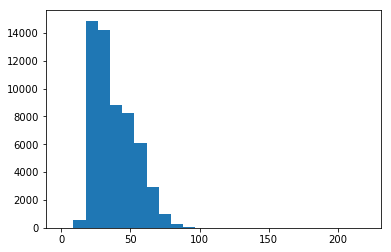

In [8]:
df_a = df.copy()
df_a.subject_age = pd.to_numeric(df_a.subject_age, errors='coerce')
plt.hist(df_a['subject_age'], 25)
f1 = plt.gcf()

While we can get some useful information out of the histogram as-is, it might be better if we eliminated some outliers. To do so, we'll remove all rows where the data for the subject ages exceeds +/- 3 standard deviations above or below the mean, and replot the histogram.

In [9]:
mean = df_a['subject_age'].mean()
std3 = 3 * df_a['subject_age'].std()
std_max = mean + std3
std_min = mean - std3
df_a = df_a[df_a['subject_age'] > std_min]
df_a = df_a[df_a['subject_age'] < std_max]
df_a = df_a[df_a['subject_age'] > 10]

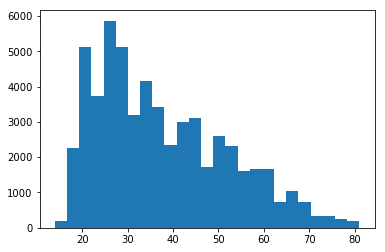

In [10]:
df_a.subject_age = pd.to_numeric(df_a.subject_age, errors='coerce')
plt.hist(df_a['subject_age'], 25)
f1 = plt.gcf()

Here we can properly see the age distribution of people committing traffic violations. We can see a definitive skew towards younger drivers, although it appears there are much more violations within people in their mid 20's and mid 30's, rather than teenagers as we initially suspected.

Next, lets take a look at which sex of drivers were pulled over more frequently. For this, a simple bar graph will be useful as well.

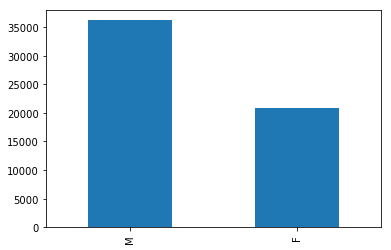

In [11]:
df['subject_sex'].value_counts().plot(kind='bar')
f1 = plt.gcf()

We can see here that there have been almost twice as many male drivers pulled over for traffic violations as there have been female drivers. While this does contradict our hypothesis that female drivers are pulled over more frequently, so far this data doesn't indicate specifically that male drivers are pulled more often, as it may be possible that there are more male drivers on the road in general than there are female.

In [35]:
df.arrested = df.arrested.replace({"y" : "Y", "n" : "N"})
df.searched = df.searched.replace({"y" : "Y", "n" : "N"})
df = df[df.searched != '\\']

df_hispanic = df[df['subject_race'] == 'H']
df_male = df[df['subject_sex'] == 'M']
df_female = df[df['subject_sex'] == 'W']

w_arrests = df[df['subject_race'] == 'W']['arrested'].value_counts()
w_searches = df[df['subject_race'] == 'W']['searched'].value_counts()
b_arrests = df[df['subject_race'] == 'B']['arrested'].value_counts()
b_searches = df[df['subject_race'] == 'B']['searched'].value_counts()
h_arrests = df[df['subject_race'] == 'H']['arrested'].value_counts()
h_searches = df[df['subject_race'] == 'H']['searched'].value_counts()

w_search_ratio = (w_searches[1]) / (w_searches[0] + w_searches[1]) * 100
b_search_ratio = (b_searches[1]) / (b_searches[0] + b_searches[1]) * 100
h_search_ratio = (h_searches[1]) / (h_searches[0] + h_searches[1]) * 100
print('Percentage of white drivers searched during a traffic violation:', w_search_ratio)
print('Percentage of black drivers searched during a traffic violation:', b_search_ratio)
print('Percentage of hispanic drivers searched during a traffic violation:', h_search_ratio)

w_arrest_ratio = (w_arrests[1]) / (w_arrests[0] + w_arrests[1]) * 100
b_arrest_ratio = (b_arrests[1]) / (b_arrests[0] + b_arrests[1]) * 100
h_arrest_ratio = (h_arrests[1]) / (h_arrests[0] + h_arrests[1]) * 100
print('Percentage of white drivers arrested as the result of a traffic violation:', w_arrest_ratio)
print('Percentage of black drivers arrested as the result of a traffic violation:', b_arrest_ratio)
print('Percentage of hispanic drivers arrested as the result of a traffic violation:', h_arrest_ratio)

Percentage of white drivers searched during a traffic violation: 1.73791605245
Percentage of black drivers searched during a traffic violation: 6.2488679587
Percentage of hispanic drivers searched during a traffic violation: 3.9373017354

Percentage of white drivers arrested as the result of a traffic violation: 0.713786950112
Percentage of black drivers arrested as the result of a traffic violation: 1.91994203949
Percentage of hispanic drivers arrested as the result of a traffic violation: 1.21291285688


## Conclusions & Discussion